# Audio recognition

In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

#from tensorflow.keras import layers
#from tensorflow.keras import models
from IPython import display

# Hides output while after model learned
from IPython.display import clear_output

import sys
#set path
sys.path.insert(1, '../')

from utils.reader_config import config_reader
from utils.figures import plot_history
from utils.models import ModelVoice, my_callbacks

In [4]:
# Import parameters
config = config_reader('../config/config.json')

# Set the seed value for experiment reproducibility.
random_seed = config.random_seed
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
#from tensorflow.python.framework import random_seed
#random_seed.set_seed(random_seed)

path_figures = config.path_figures
path_data = config.data_dir #+ 'train/audio/'
path_models = '../models/'
print(path_models,'\n', path_data)

## Import data

[The Speech Commands dataset dataset](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data) consists of over 64,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people either saying 30 different words or making some noise.

In [312]:
# DATASET_PATH = '../data/'

# data_dir = pathlib.Path(DATASET_PATH)
# # if not data_dir.exists():
# #   	tf.keras.utils.get_file(
# # 		'mini_speech_commands.zip',
# # 		origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
# # 		extract=True,
# # 		cache_dir='.', cache_subdir='data')

In [53]:
data_dir = path_data
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('There are {} different commands:\n {}'.format(len(commands), commands))

There are 31 different commands:
 ['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero'
 '_background_noise_']


The dataset's audio clips are stored in multiple folders corresponding to each speech command: `yes`,`no`, `up`, `down`, `go`, `stop`, `left`, `right`, `on`, and `off`. Other labels should be considered either `silence` or `unknown`. The folder _background_noise_ contains longer clips of "silence" that we can break up and use as training input. 

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched. Let us read the data and split the data into two samples.

In [55]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=config.data_dir + 'train/audio/', 
    batch_size=64, 
    output_sequence_length=16000, # clip duration
    seed=random_seed, 
    subset='both',
    validation_split=0.2
)
label_names = np.array(train_ds.class_names)

Found 64727 files belonging to 31 classes.
Using 51782 files for training.
Using 12945 files for validation.


In [ ]:
# val_ds = tf.keras.utils.audio_dataset_from_directory(
#     directory=config.data_dir + 'test/', batch_size=64, output_sequence_length=16000)

The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [56]:
print(train_ds.element_spec)
train_ds

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


<_BatchDataset element_spec=(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

This dataset, which consists of a number of batches, only contains single channel audio, so we can use the `tf.squeeze` function to drop the extra axis:

In [57]:
def squeeze(audio, labels):
	audio = tf.squeeze(audio, axis=-1)
	return audio, labels

classes = ['up', 'down', 'go', 'stop', 'left', 'right', 'yes', 'no' , 'on', 'off', 'silence', 'unknown']
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
train_ds

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction. 

In [58]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [59]:
for example_audio, example_labels in train_ds.take(1):  
	print(example_audio.shape)
	print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [60]:
label_names[[1,1,3,0]]

array(['bed', 'bed', 'cat', '_background_noise_'], dtype='<U18')

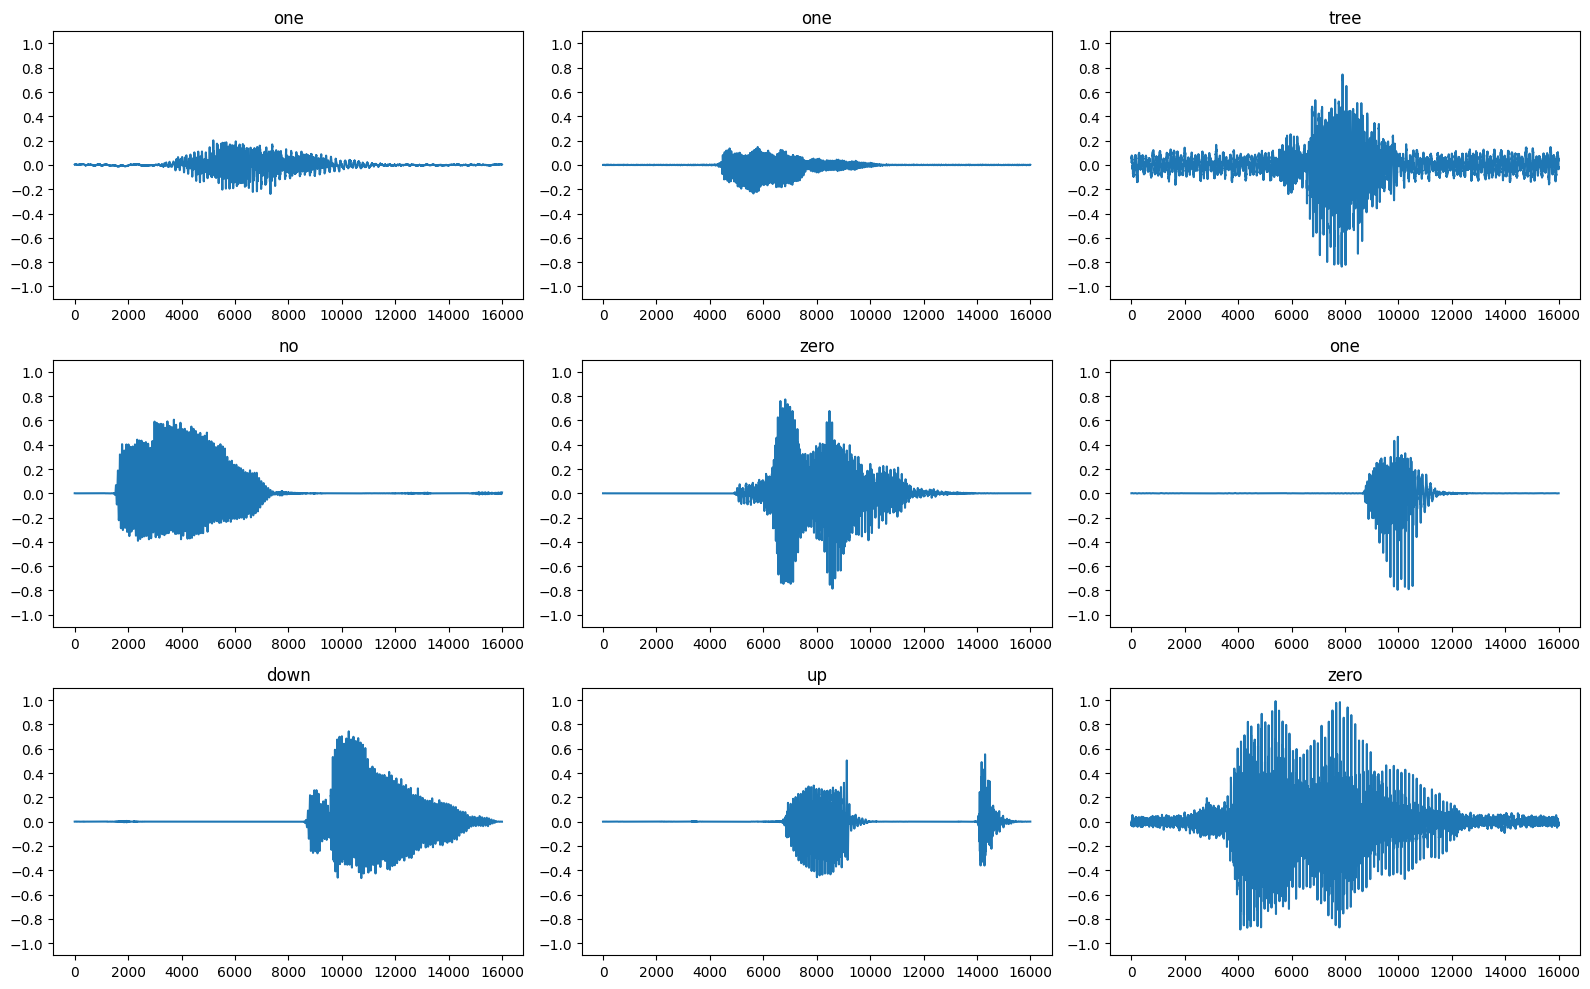

In [64]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
	plt.subplot(rows, cols, i+1)
	audio_signal = example_audio[i]
	plt.plot(audio_signal)
	plt.title(label_names[example_labels[i]])
	plt.yticks(np.arange(-1.2, 1.2, 0.2))
	plt.ylim([-1.1, 1.1])
plt.tight_layout();

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, they will be converted from the time-domain signals into the time-**frequency**-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [65]:
def get_spectrogram(waveform):
	# Convert the waveform to a spectrogram via a STFT.
	spectrogram = tf.signal.stft(
		waveform, frame_length=255, frame_step=128)
	# Obtain the magnitude of the STFT.
	spectrogram = tf.abs(spectrogram)
	# Add a `channels` dimension, so that the spectrogram can be used
	# as image-like input data with convolution layers (which expect
	# shape (`batch_size`, `height`, `width`, `channels`).
	spectrogram = spectrogram[..., tf.newaxis]
 
	return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [66]:
for i in range(3):
	label = label_names[example_labels[i]]
	waveform = example_audio[i]
	spectrogram = get_spectrogram(waveform)

	print('Label:', label)
	print('Waveform shape:', waveform.shape)
	print('Spectrogram shape:', spectrogram.shape)
	print('Audio playback')
	display.display(display.Audio(waveform, rate=16000))

Label: one
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: one
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: tree
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [67]:
def plot_spectrogram(spectrogram, ax):
	if len(spectrogram.shape) > 2:
		assert len(spectrogram.shape) == 3
		spectrogram = np.squeeze(spectrogram, axis=-1)
	# Convert the frequencies to log scale and transpose, so that the time is
	# represented on the x-axis (columns).
	# Add an epsilon to avoid taking a log of zero.
	log_spec = np.log(spectrogram.T + np.finfo(float).eps)
	height = log_spec.shape[0]
	width = log_spec.shape[1]
	X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
	Y = range(height)
	ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

In [68]:
waveform

<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([ 0.02511597,  0.03085327,  0.03796387, ..., -0.02676392,
       -0.01867676, -0.01977539], dtype=float32)>

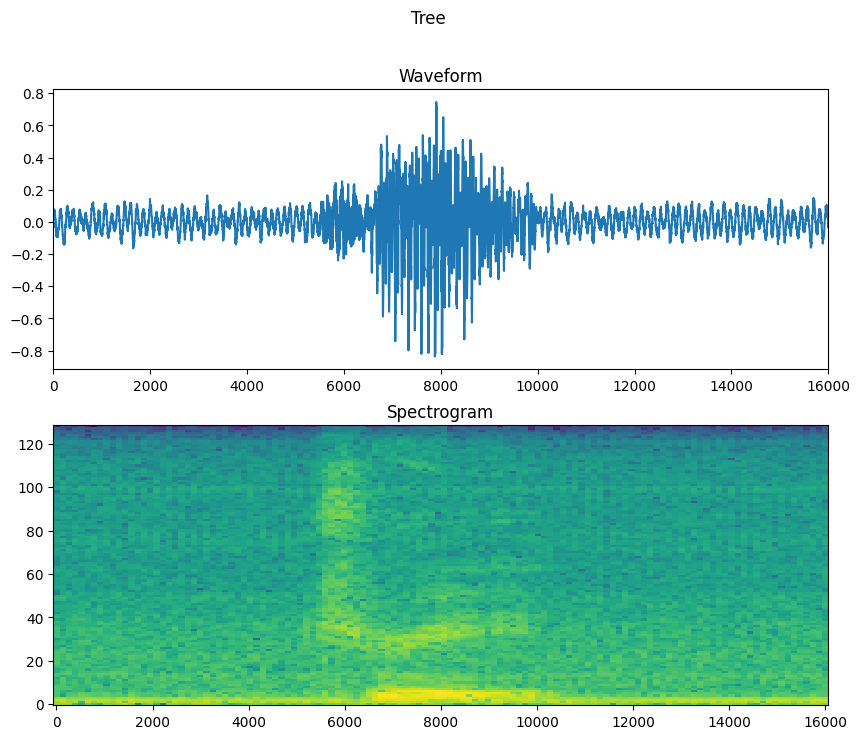

In [69]:
fig, axes = plt.subplots(2, figsize=(10, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title());

Now, create spectrogram datasets from the audio datasets:

In [70]:
def make_spec_ds(ds):
  	return ds.map(map_func=lambda audio, label: \
       (get_spectrogram(audio), label),  num_parallel_calls=tf.data.AUTOTUNE)

In [71]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [72]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
	break

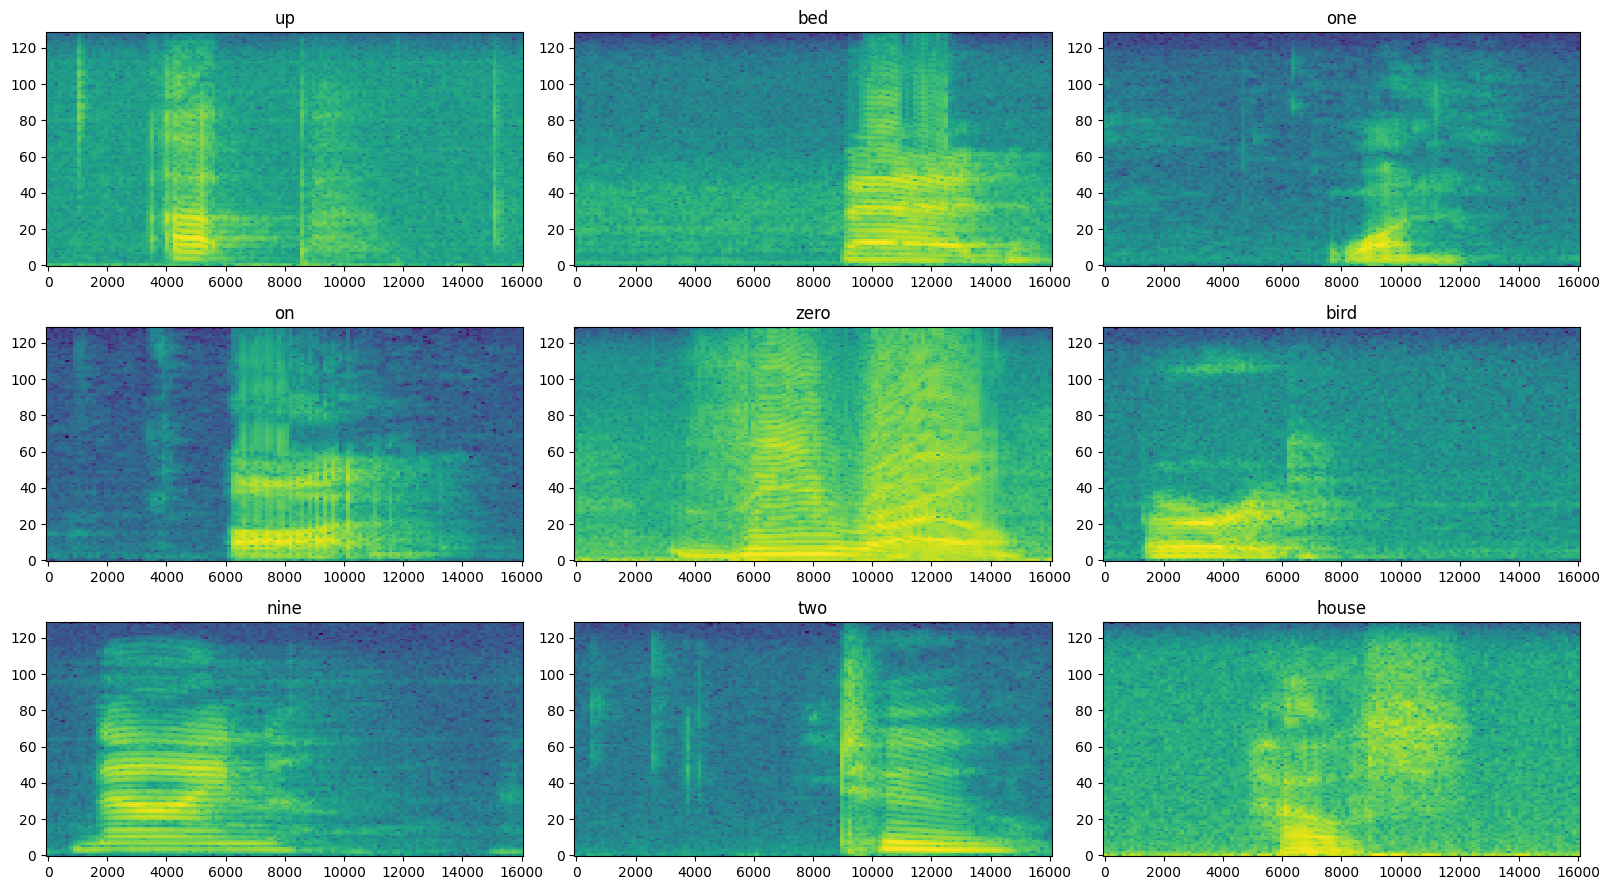

In [73]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])
plt.tight_layout();

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [331]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [332]:
input_shape = example_spectrograms.shape[1:]
input_shape

TensorShape([124, 129, 1])

In [425]:
# input_shape = example_spectrograms.shape[1:]
# #print('Input shape:', input_shape)
# num_labels = len(label_names)

# # Instantiate the `tf.keras.layers.Normalization` layer.
# norm_layer = layers.Normalization()
# # Fit the state of the layer to the spectrograms
# # with `Normalization.adapt`.
# norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

# model = models.Sequential([
#     layers.Input(shape=input_shape),
#     # Downsample the input.
#     layers.Resizing(32, 32),
#     # Normalize.
#     norm_layer,
#     layers.Conv2D(32, 3, activation='relu'),
#     layers.Conv2D(64, 3, activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_labels),
# ])

# model.summary(line_length=80)

Model: "sequential_10"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 resizing_105 (Resizing)            (None, 32, 32, 1)               0           
                                                                                
 normalization_130 (Normalization)  (None, 32, 32, 1)               3           
                                                                                
 conv2d_130 (Conv2D)                (None, 30, 30, 32)              320         
                                                                                
 conv2d_131 (Conv2D)                (None, 28, 28, 64)              18496       
                                                                                
 max_pooling2d_47 (MaxPooling2D)    (None, 14, 14, 64)              0           
                                                                                
 drop

In [431]:
#from tensorflow.keras import Model
# from keras.optimizers import Adam
# from keras import layers

# class ModelVoice(tf.keras.Model):
#     def __init__(self, **kwargs):
#         super(ModelVoice, self).__init__(**kwargs)
#         self.d1 = layers.Resizing(32, 32, name='Resizing')
#         self.d2 = layers.Normalization(name='Normalization')
#         self.d2.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))
#         self.d3 = layers.Conv2D(32, 3, activation='relu', name='Convol_1')
#         self.d4 = layers.Conv2D(64, 3, activation='relu', name='Convol_2')
#         self.d5 = layers.MaxPooling2D(name='MaxPooling2D')
#         #self.Dropout_1 = layers.Dropout(0.25, name='Dropout_0.25')
#         self.d6 = layers.Dropout(0.25, name='Dropout_0.25')
#         self.d7 = layers.Flatten(name='Flatten')
#         self.d8 = layers.Dense(128, activation='relu', name='Dense_128')
#         self.d9 = layers.Dropout(0.5, name='Dropout_0.5')
#         self.output_channel = layers.Dense(units=31, name='Dense_31')

#     def call(self, inputs, training=False): #, training=False
#         #print('initial: ', inputs.shape)
#         #x = self.d7(x)
#         #print('next: ', x.shape)
#         x = self.d1(inputs)
#         #print('After resizing: ', x.shape)
#         x = self.d2(x)
#         x = self.d3(x) 
#         x = self.d4(x) 
#         x = self.d5(x) 
#         x = self.d6(x)
#         #x = self.Dropout_1(x, training=training)
#         x = self.d7(x) 
#         x = self.d8(x) 
#         x = self.d9(x)
#         x = self.output_channel(x)
#         #print('Output: ', x.shape)
#         return x
#         #print(f"input_shape = {(self.n_timesteps, self.n_channels)} | output_units = {self.output_channels.shape}")

my_shape = example_spectrograms.shape[1:]
# print('Input shape is: ',my_shape, '\nNum labels:', num_labels, 
#     '\noriginal:', X[0].shape,
#     '\nShape to the model:', tf.squeeze(X[0]).shape,'\n')
model = ModelVoice()
model.build(input_shape= my_shape)
model.call(tf.keras.layers.Input(shape = (64, 124, 1)))
model.summary(line_length=80)

Model: "model_voice_119"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 Resizing (Resizing)                (None, 32, 32, 1)               0           
                                                                                
 Normalization (Normalization)      (None, 32, 32, 1)               3           
                                                                                
 Convol_1 (Conv2D)                  (None, 30, 30, 32)              320         
                                                                                
 Convol_2 (Conv2D)                  (None, 28, 28, 64)              18496       
                                                                                
 MaxPooling2D (MaxPooling2D)        (None, 14, 14, 64)              0           
                                                                                
 Dr

In [521]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
 
# def callbacks(model_name:str, path_models:str,
#     reduce_patience:int,
#     stop_patience:int,
#     monitor:str,
#     verbose:bool,
#     mode:str,
#     save_best_only:bool,
#     save_weights_only:bool,
#     restore_best_weights:bool,
#     cooldown_epochs:int,
#     lr:float,
#     factor:float
#     ):
#     """ Manages the learning process of our model

#     Args:
#         model_name (str): model name
#         path_models (str): path to save
#         reduce_patience (int): decreases the lr when metrics doesn't change
#         stop_patience (int): the number of epochs before the learning process is terminated if the metric doesn't change
#         monitor (str): metric to monitor
#         verbose (bool): shows the output
#         mode (str): study mode
#         save_best_only (bool): saves models with improved quality
#         save_weights_only (bool): _description_
#         restore_best_weights (bool): _description_
#         cooldown_epochs (int): wait period when 
#         lr (float): the learning rate
#         factor (float): learning rate decrease factor (0,1)
#     """

#     # End training if the metric doesn't imporve
#     earlystop = EarlyStopping(
#         monitor=monitor,
#         mode=mode,
#         patience=stop_patience,
#         restore_best_weights=restore_best_weights,
#         verbose=verbose
#     )

#     # Decrease learning rate if the metric doesn't improve 
#     reduce_lr = ReduceLROnPlateau(
#         monitor=monitor, 
#         mode=mode,  
#         min_lr=lr/1000,
#         factor=factor, 
#         patience=reduce_patience,
#         cooldown=cooldown_epochs,
#         verbose=verbose
#     )
    
#     checkpoint = ModelCheckpoint(
#         filepath=os.path.join(path_models, model_name + '.weights.h5'), #full: '_model.keras' subclass:.h5
#         #save_format="tf", # saves a subclassed model
#         save_best_only=save_best_only, 
#         save_weights_only=save_weights_only,
#         monitor=monitor, 
#         mode=mode,
#         verbose=verbose        
#     )

#     # # reduces learnign rate smoothly
#     # scheduler = LearningRateScheduler(
#     #     schedule=smooth_decay(epoch, lr), 
#     #     verbose=config.callbacks.verbose
#     # )

#     return [checkpoint, earlystop, reduce_lr] 

In [522]:
#"//": "Функция Callbacks",
cb={"model_name":'Model_voice',
    'cooldown_epochs':1,
    "lr":1e-4,
    "reduce_patience":10,
    "stop_patience":150,
    "monitor":"val_accuracy",
    "verbose":1,
    "mode":"max",
    'save_weights_only':True, 
    "save_best_only": True,
    "restore_best_weights": True,
    "factor": 0.9}

In [536]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),#learning_rate=lr)
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

EPOCHS = 15
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=callbacks_1(path_models=path_models, **cb) #tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)
clear_output(wait=False)

plot_history(history, 1)

In [373]:
np.resize(X[0], [64,128,128,1]).shape

(64, 128, 128, 1)

In [503]:
#tf.reshape(tf.squeeze(X[0]), [32, 32])
tf.shape(tf.squeeze(X[0]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 64, 124, 129])>

In [260]:
X, y = tuple(zip(*train_spectrogram_ds))
print(X[0].shape)
tf.squeeze(X[0]).shape

(64, 124, 129, 1)


TensorShape([64, 124, 129])

In [230]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))
norm_layer

In [118]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
model.fit(train_spectrogram_ds.take(1))
tf.keras.utils.plot_model(model, show_shapes=True)

TypeError: in user code:

    File "C:\Users\Professional\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Professional\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Professional\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Professional\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Professional\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\PROFES~1\AppData\Local\Temp\__autograph_generated_filetda5glbz.py", line 10, in tf__call
        x = ag__.converted_call(ag__.ld(self).d0, (ag__.ld(x),), None, fscope)

    TypeError: Exception encountered when calling layer 'model_voice_17' (type ModelVoice).
    
    in user code:
    
        File "C:\Users\Professional\AppData\Local\Temp\ipykernel_1700\2456218730.py", line 31, in call  *
            x = self.d0(x)
    
        TypeError: 'KerasTensor' object is not callable
    
    
    Call arguments received by layer 'model_voice_17' (type ModelVoice):
      • x=tf.Tensor(shape=(None, 124, 129, 1), dtype=float32)
      • training=True


Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [ ]:

    # def build_model(self, model_name:str='my_model_name', lr:float=0.001, show_summary:bool=False):
    #     """Метод формирования модели
    #     """
    #     model = Model(
    #         inputs=self.input_channels,
    #         outputs=self.output_channels,
    #         name=model_name #"LSTM_model"
    #     )
        
    #     optimizer = Adam(learning_rate=lr)
    #     model.compile(loss='mse', metrics = ['mae', 'mse'], 
    #                 optimizer=optimizer)

    #     if show_summary:       
    #         model.summary()
    #         print(f"input_shape = {(self.n_timesteps, self.n_channels)} | output_units = {self.output_channels.shape}")
        
        
    #     return model

In [76]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [29]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
810/810 [==============================] - 67s 81ms/step - loss: 2.1148 - accuracy: 0.3884 - val_loss: 1.0832 - val_accuracy: 0.7058
Epoch 2/10
810/810 [==============================] - 53s 65ms/step - loss: 1.2092 - accuracy: 0.6415 - val_loss: 0.7537 - val_accuracy: 0.7877
Epoch 3/10
810/810 [==============================] - 53s 65ms/step - loss: 0.9607 - accuracy: 0.7102 - val_loss: 0.6320 - val_accuracy: 0.8253
Epoch 4/10
810/810 [==============================] - 52s 65ms/step - loss: 0.8323 - accuracy: 0.7450 - val_loss: 0.5776 - val_accuracy: 0.8369
Epoch 5/10
810/810 [==============================] - 52s 65ms/step - loss: 0.7435 - accuracy: 0.7716 - val_loss: 0.5229 - val_accuracy: 0.8519
Epoch 6/10
810/810 [==============================] - 52s 65ms/step - loss: 0.6914 - accuracy: 0.7871 - val_loss: 0.5193 - val_accuracy: 0.8540
Epoch 7/10
810/810 [==============================] - 52s 65ms/step - loss: 0.6265 - accuracy: 0.8046 - val_loss: 0.4705 - val_accuracy:

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

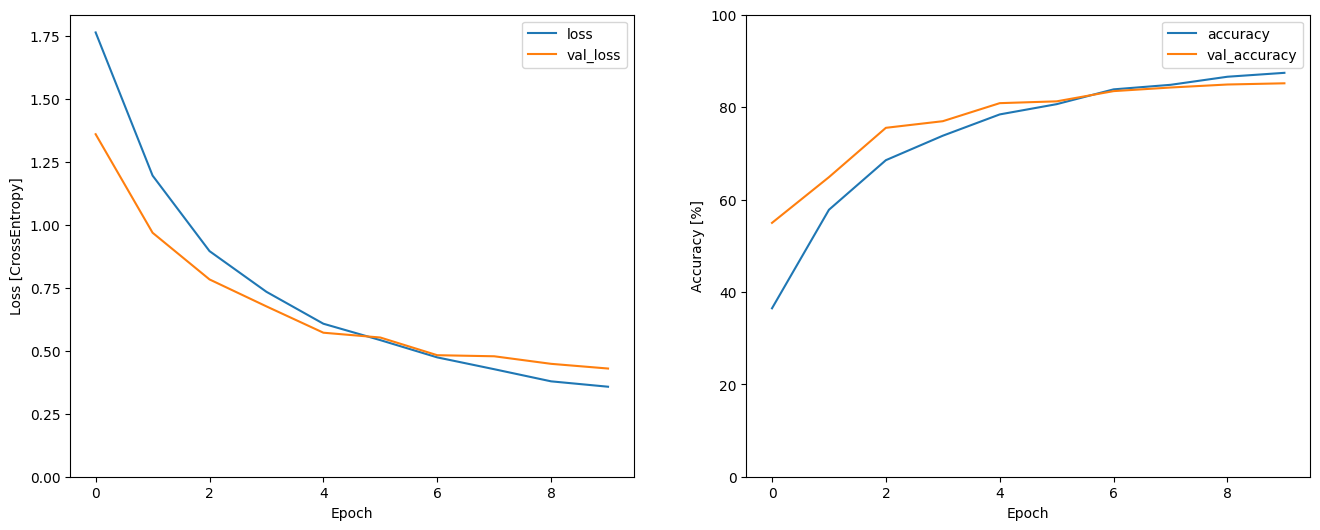

In [45]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]');

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [46]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 1s 30ms/step - loss: 0.5147 - accuracy: 0.8534


{'loss': 0.5147382020950317, 'accuracy': 0.8533653616905212}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [47]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 0s 14ms/step


In [48]:
y_pred = tf.argmax(y_pred, axis=1)

In [49]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

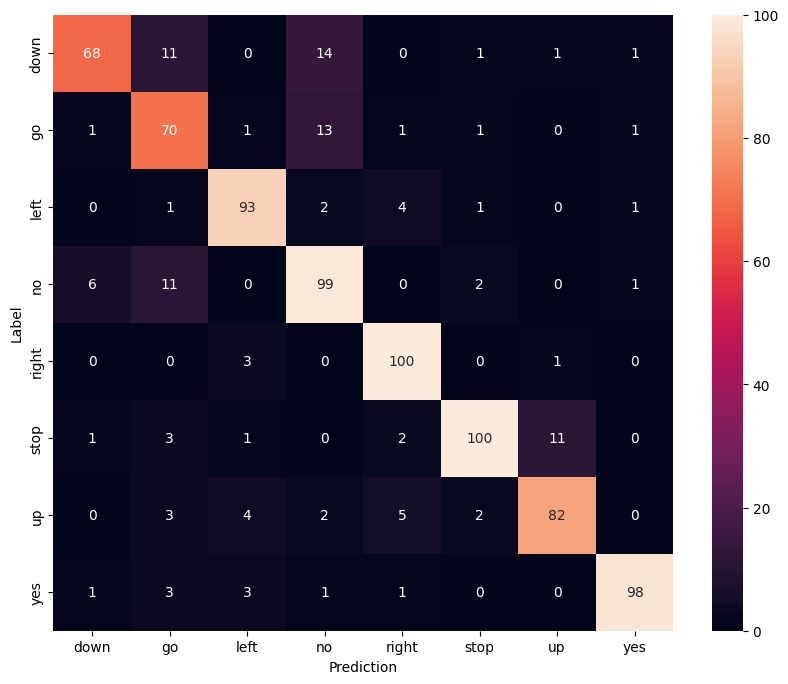

In [50]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [89]:
# test_file = tf.io.read_file(DATASET_PATH+'mini_speech_commands_extracted/mini_speech_commands/down/0a9f9af7_nohash_0.wav')
# test_audio, _ = tf.audio.decode_wav(contents=test_file)
# test_audio = np.array(test_audio)
# test_audio

<tf.Tensor: shape=(13654, 1), dtype=float32, numpy=
array([[0.00177002],
       [0.00299072],
       [0.00283813],
       ...,
       [0.02526855],
       [0.02972412],
       [0.01776123]], dtype=float32)>

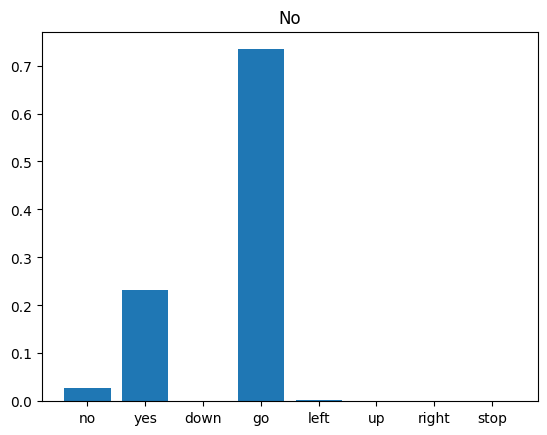

In [93]:
'../data/mini_speech_commands_extracted/mini_speech_commands/no/01bb6a2a_nohash_0.wav' #data_dir + 'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [32]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [33]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 1.0958828,  2.526922 , -1.8349309,  4.2553926, -4.2595496,
         -2.5386834, -3.6104631, -2.295511 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [34]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 1.0958828,  2.526922 , -1.8349309,  4.2553926, -4.2595496,
         -2.5386834, -3.6104631, -2.295511 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The 
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.